In [1]:
! pip install -q pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import pyspark
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.window import Window

Инициализируем Spark сессию

SparkSession:
- входная точка в Spark
- способ инициализации базовой функциональности PySpark
- "под капотом" SparkSession создаем экземпляр класса SparkContext и SparkConfig

Параметры:
- master():
  - при работе с кластером необходимо передать имя кластерного менеджера, например "yarn".
  - при локальной работе необходимо указать "local[*]". Значение в скобках в идеале должно соответствовать кол-ву ядер процессора.

- appName():
  - используется для определения имени приложения.

In [3]:
spark = SparkSession.builder\
                    .master("local[*]")\
                    .appName("spark_worflow")\
                    .getOrCreate()

In [4]:
spark

**Чтение данных в Spark**

In [ ]:
# Чтение CSV файла
csv_file = 'data/test.csv'
data_csv = spark.read.csv(csv_file)

# Чтение JSON файла
json_file = 'data/test.json'
data_json = spark.read.json(json_file)

# Чтение Parquet файла
parquet_file = 'data/test.parquet'
data_parquet = spark.read.parquet(parquet_file)

# Чтение данных с HDFS
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("connect_to_hdfs").setMaster("local")
sc = SparkContext(conf=conf)

hdfs_file = sc.textFile("hdfs://namenodehost/inputFiles/test.txt")
hdfs_file.first()

Попробуем прочитать данные из csv

In [5]:
csv_file = 'fraud.csv'
data_fraud = spark.read.csv(csv_file
                           ,header=True)

In [6]:
type(data_fraud)

pyspark.sql.dataframe.DataFrame

In [7]:
data_fraud.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Unnamed: 0: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- is_fraud: string (nullable = true)



In [8]:
data_fraud.show(5)

+-------+----------+---------------------+----------------+--------------------+-------------+-----+--------+--------+------+--------------------+------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+---------+-----------+--------+
|    _c0|Unnamed: 0|trans_date_trans_time|          cc_num|            merchant|     category|  amt|   first|    last|gender|              street|        city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|merch_lat| merch_long|is_fraud|
+-------+----------+---------------------+----------------+--------------------+-------------+-----+--------+--------+------+--------------------+------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+---------+-----------+--------+
| 811778|    811778|  2019-12-07 10:55:06|    676173792455|fraud_Zieme, Bode...|gas_transport|86.19|Brittany|     Cox|

Spark не всегда умеет корректно определять типы данных
  
Чтобы задать другие типы данных можно заранее определить схему данных с помощью класса StructType, которые состоит из коллекции объектов StructField

In [9]:
from pyspark.sql.types import *

# IntegerType()
# StringType()
# LongType()
# DateType()
# TimestampType()
# DoubleType()
# BooleanType()

data_schema = [
StructField('_c0', IntegerType(), True),
StructField('id', IntegerType(), True),
StructField('trans_dt', DateType(), True),              #
StructField('cc_num', IntegerType(), True),             #
StructField('merchant', StringType(), True),
StructField('category', StringType(), True),
StructField('amt', DoubleType(), True),
StructField('first', StringType(), True),
StructField('last', StringType(), True),
StructField('gender', StringType(), True),
StructField('street', StringType(), True),
StructField('city', StringType(), True),
StructField('state', StringType(), True),
StructField('zip', IntegerType(), True),
StructField('lat', DoubleType(), True),
StructField('long', DoubleType(), True),
StructField('city_pop', IntegerType(), True),
StructField('job', StringType(), True),
StructField('dob', DateType(), True),
StructField('trans_num', StringType(), True),
StructField('unix_time', IntegerType(), True),
StructField('merch_lat', DoubleType(), True),
StructField('merch_long', DoubleType(), True),
StructField('is_fraud', BooleanType(), True)            #
]

structure = StructType(fields = data_schema)

Снова прочитаем данные и передадим созданную схему в качестве параметра

In [10]:
csv_file = 'fraud.csv'
data_fraud = spark.read.csv(csv_file
                           ,header=True
                           ,schema=structure)

data_fraud.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- trans_dt: date (nullable = true)
 |-- cc_num: integer (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: boolean (nullable = true)



In [11]:
data_fraud.show(5)

+-------+-------+----------+------+--------------------+-------------+-----+--------+--------+------+--------------------+------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+---------+-----------+--------+
|    _c0|     id|  trans_dt|cc_num|            merchant|     category|  amt|   first|    last|gender|              street|        city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|merch_lat| merch_long|is_fraud|
+-------+-------+----------+------+--------------------+-------------+-----+--------+--------+------+--------------------+------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+---------+-----------+--------+
| 811778| 811778|2019-12-07|  NULL|fraud_Zieme, Bode...|gas_transport|86.19|Brittany|     Cox|     F|07177 William Dal...|Santa Monica|   CA|90403|34.0287|-118.4924|   92043|Civil engineer, 

Можно заметить, что не все значения определились корректно.

Заменим типы данных для этих полей.

In [ ]:
data_fraud.dtypes

[('_c0', 'int'),
 ('id', 'int'),
 ('trans_dt', 'date'),
 ('cc_num', 'int'),
 ('merchant', 'string'),
 ('category', 'string'),
 ('amt', 'double'),
 ('first', 'string'),
 ('last', 'string'),
 ('gender', 'string'),
 ('street', 'string'),
 ('city', 'string'),
 ('state', 'string'),
 ('zip', 'int'),
 ('lat', 'double'),
 ('long', 'double'),
 ('city_pop', 'int'),
 ('job', 'string'),
 ('dob', 'date'),
 ('trans_num', 'string'),
 ('unix_time', 'int'),
 ('merch_lat', 'double'),
 ('merch_long', 'double'),
 ('is_fraud', 'boolean')]

Как можно смотреть данные датафрейма:

In [ ]:
data_fraud.show()  # по умолчанию покажет первые 20 строк

+-------+-------+----------+------+--------------------+-------------+-----+--------+-----------+------+--------------------+----------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-------------------+--------+
|    _c0|     id|  trans_dt|cc_num|            merchant|     category|  amt|   first|       last|gender|              street|            city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|         merch_long|is_fraud|
+-------+-------+----------+------+--------------------+-------------+-----+--------+-----------+------+--------------------+----------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-------------------+--------+
| 811778| 811778|2019-12-07|  NULL|fraud_Zieme, Bode...|gas_transport|86.19|Brittany|        Cox|     F|07177 William 

In [ ]:
data_fraud.first()  # возвращает первую строку

Row(_c0=811778, id=811778, trans_dt=datetime.date(2019, 12, 7), cc_num=None, merchant='fraud_Zieme, Bode and Dooley', category='gas_transport', amt=86.19, first='Brittany', last='Cox', gender='F', street='07177 William Dale Apt. 547', city='Santa Monica', state='CA', zip=90403, lat=34.0287, long=-118.4924, city_pop=92043, job='Civil engineer, contracting', dob=datetime.date(1961, 4, 25), trans_num='f32d1f4b2a918f4c2f6acdc83033ee35', unix_time=1354877706, merch_lat=33.287851, merch_long=-118.74097, is_fraud=None)

In [ ]:
data_fraud.head(3)  # возвращает первые N строк в виде списка

[Row(_c0=811778, id=811778, trans_dt=datetime.date(2019, 12, 7), cc_num=None, merchant='fraud_Zieme, Bode and Dooley', category='gas_transport', amt=86.19, first='Brittany', last='Cox', gender='F', street='07177 William Dale Apt. 547', city='Santa Monica', state='CA', zip=90403, lat=34.0287, long=-118.4924, city_pop=92043, job='Civil engineer, contracting', dob=datetime.date(1961, 4, 25), trans_num='f32d1f4b2a918f4c2f6acdc83033ee35', unix_time=1354877706, merch_lat=33.287851, merch_long=-118.74097, is_fraud=None),
 Row(_c0=1101718, id=1101718, trans_dt=datetime.date(2020, 4, 3), cc_num=None, merchant='fraud_Lind-Buckridge', category='entertainment', amt=85.81, first='Tamara', last='Martinez', gender='F', street='471 Marquez Prairie Suite 680', city='Matthews', state='MO', zip=63867, lat=36.7154, long=-89.6287, city_pop=1019, job='Aeronautical engineer', dob=datetime.date(1979, 1, 26), trans_num='f5dad8e2d7c39d81502d846a20286659', unix_time=1364994606, merch_lat=36.53995, merch_long=-89

In [ ]:
data_fraud.columns

['_c0',
 'id',
 'trans_dt',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

In [ ]:
data_fraud.count()

Пример "ленивой" операции (трансформации)

In [ ]:
data_fraud.distinct()

Пример "ленивой" операции (трансформации) с последующим действием

In [ ]:
data_fraud.distinct().show()

In [ ]:
data_fraud.describe()

Добавление новой колонки

In [ ]:
data_fraud = data_fraud.withColumn('new_column', data_fraud.id)

In [ ]:
data_fraud.printSchema()

Переименование колонки

In [ ]:
data_fraud.withColumnRenamed('new_column', 'new_column_2')

Удаление колонки

In [ ]:
data_fraud.drop('new_column')

Выборка данных

In [12]:
data_fraud.select(['id', 'is_fraud'])

DataFrame[id: int, is_fraud: boolean]

In [13]:
data_fraud.select(['id', 'is_fraud']).show(5)

+-------+--------+
|     id|is_fraud|
+-------+--------+
| 811778|    NULL|
|1101718|    NULL|
| 800013|    NULL|
| 398945|    NULL|
| 207455|    NULL|
+-------+--------+
only showing top 5 rows



In [ ]:
data_fraud.show(3)

In [ ]:
data_fraud.filter(data_fraud.id < 10).show(3)

Посчитаем кол-во фродовых операций в датасете

In [ ]:
# code here

Фильтр по значению подстроки

In [ ]:
data_fraud.filter(data_fraud.merchant.rlike('Prohaska')).show()

Посчитаем сумму транзакций каждого продавца

In [ ]:
# code here

Для более красивого вывода можно применить метод toPandas

In [ ]:
# code here

Посчитаем различные агрегационные значения одновременно

Метод .alias задает псевдоним для колонки. Наподобие AS в SQL.

In [ ]:
from pyspark.sql import functions as f

data_fraud \
    .groupBy("merchant") \
    .agg(f.min("trans_dt").alias("С"),
         f.max("trans_dt").alias("По"),

         f.min("amt").alias("Минимальная сумма"),
         f.max("amt").alias("Максимальная сумма"),
         f.avg("amt").alias("Средняя сумма"),

      ).show()

Сохраним результат группировки в переменную

In [ ]:
grouped_fraud_data = data_fraud \
    .groupBy("merchant") \
    .agg(f.min("trans_dt").alias("С"),
         f.max("trans_dt").alias("По"),

         f.min("amt").alias("Минимальная сумма"),
         f.max("amt").alias("Максимальная сумма"),
         f.avg("amt").alias("Средняя сумма"),

      )

In [ ]:
grouped_fraud_data.toPandas()

In [ ]:
type(grouped_fraud_data)

In [ ]:
type(grouped_fraud_data.toPandas())

**Сохранение данных в файл**

In [ ]:
# CSV
grouped_fraud_data.write.mode("overwrite").csv('data_fraud.csv')

# JSON
grouped_fraud_data.write.mode("overwrite").save('data_fraud.json', format='json')

# Parquet
grouped_fraud_data.write.mode("overwrite").save('data_fraud.parquet', format='parquet')

# RDD

- В качестве объекта распределения фреймворк Spark использует данные наборов RDD, поэтому для осуществления распределения необходимо преобразовывать исходные данные в набор RDD.

Создадим список Python и преобразуем его в формат RDD c помощью соответствующей функции.

![image.png](
  
)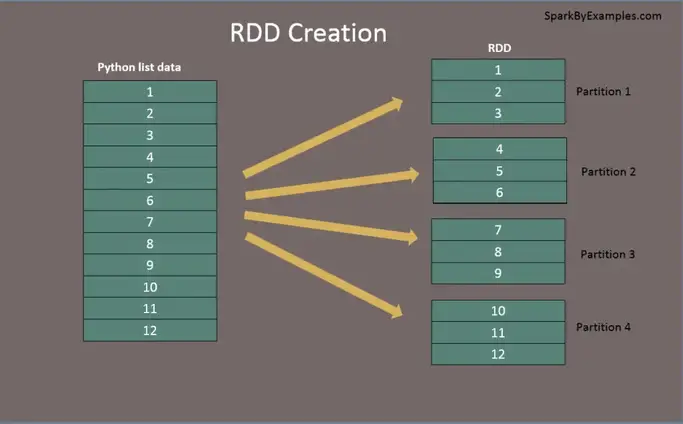

In [14]:
python_list = [1,2,3,4,5,6,7,8,9,10]

Разделим наш список на несколько частей.

In [15]:
rdd_example = spark.sparkContext.parallelize(python_list)

Посмотрим сколько частей создалось.

In [16]:
rdd_example.getNumPartitions()

2

Зададим кол-во частей вручную.

In [17]:
rdd_example_5 = spark.sparkContext.parallelize(python_list, 5)

In [18]:
rdd_example_5.getNumPartitions()

5

Можем переразбить файл на другое кол-во частей.

In [21]:
rdd_example_10 = rdd_example_5.repartition(10)

In [22]:
rdd_example_10.getNumPartitions()

10

Посмотрим содержимое.
Метод collect() позволяет получить элементы датасета в виде списка.

In [24]:
rdd_example.collect()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Метод take(n) возвращает в виде массива или списка первые n элементов:

In [25]:
rdd_example.take(3)

[1, 2, 3]

Метод count() нужен для подсчета количества элементов в датасете:

In [26]:
rdd_example.count()

10

**RDD Transformations**

Основными преобразованиями являются методы map(), filter(), distinct().

In [ ]:
rdd_example.map(lambda x: x ** 2)

In [ ]:
rdd_example.filter(lambda x: x < 5)

In [28]:
rdd_example.distinct()

[2, 4, 6, 8, 10, 1, 3, 5, 7, 9]

**RDD Actions**

In [29]:
rdd_example.count()

10

In [30]:
rdd_example.sum()

55

In [31]:
from operator import add

rdd_example.reduce(add)

55

In [32]:
rdd_example.saveAsTextFile('test')

**Преобразование DataFrame >> RDD**

In [33]:
rdd_fraud_data = grouped_fraud_data.rdd

NameError: name 'grouped_fraud_data' is not defined

In [ ]:
type(rdd_fraud_data)

In [ ]:
rdd_fraud_data.collect()

**Выведите строку со значением merchant = 'fraud_Will Ltd'**

In [ ]:
# code here

# UDF (User defined functions)

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.types import BooleanType

Преобразуем значения поля is_fraud 0/1::integer в false/true::boolean

In [ ]:
is_one_udf = F.udf(lambda x: True if x and x == 1 else False, BooleanType())

In [ ]:
data_fraud.withColumn('is_fraud', is_one_udf('id')).show()